In [1]:
!pip install langchain
!pip install langgraph
!pip install langsmith
!pip install langchain_groq
!pip install langchain_community
!pip install wikipedia
!pip install arxiv

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
wikipedia_tool = WikipediaQueryRun(api_wrapper = wikipedia_wrapper)

In [4]:
wikipedia_tool.invoke("who is Bill Gates?")

'Page: Bill Gates Sr.\nSummary: William Henry Gates II (November 30, 1925 – September 14, 2020), better known as Bill Gates Sr., was an American attorney, philanthropist, and civic leader. He was the founder of the law firm Shidler McBroom & Gates (a predecessor of K&L Gates), and also served as president of both the Seattle King County and Washington State Bar associations. He was the father of Bill Gates, co-founder of Microsoft.'

In [5]:
arxiv_tool.invoke("Critical Insights into Machine Learning and Deep Learning Approaches for Personality Prediction")

'Published: 2023-03-28\nTitle: Crime Prediction Using Machine Learning and Deep Learning: A Systematic Review and Future Directions\nAuthors: Varun Mandalapu, Lavanya Elluri, Piyush Vyas, Nirmalya Roy\nSummary: Predicting crime using machine learning and deep learning techniques has\ngained considerable attention from researchers in recent years, focusing on\nidentifying patterns and trends in crime occurrences. This review paper\nexamines over 150 articles to explore the various machine learning and deep\nlearning algorithms applied to predict crime. The study provides access to the\ndatasets used for crime prediction by researchers and analyzes prominent\napproaches applied in machine learning and deep learning algorithms to predict\ncrime, offering insights into different trends and factors related to criminal\nactivities. Additionally, the paper highlights potential gaps and future\ndirections that can enhance the accuracy of crime prediction. Finally, the\ncomprehensive overview o

In [6]:
tools = [wikipedia_tool, arxiv_tool]

In [7]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages : Annotated[list, add_messages]

Graph_builder = StateGraph(State)

Graph_builder

In [8]:
from langchain_groq import ChatGroq
from google.colab import userdata

groq = userdata.get('GROQ_API_KEY')
LLM = ChatGroq(groq_api_key = groq, model_name="Gemma2-9b-It")
LLM

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78728f2ccd90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78728f2cda50>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
LLM_tools = LLM.bind(tools=tools)

In [10]:
def Chatbot(state:State):
  return {"messages" : LLM_tools.invoke(state['messages'])}

In [11]:
from langgraph.prebuilt import ToolNode, tools_condition

Graph_builder.add_node("Chatbot",Chatbot)
tool_node = ToolNode(tools = tools)
Graph_builder.add_node("Tools", tool_node)

Graph_builder.add_conditional_edges(
    "Chatbot",
    tools_condition,
)

Graph_builder.add_edge("Tools", "Chatbot")
Graph_builder.add_edge(START,"Chatbot")
Graph_builder.add_edge("Chatbot",END)


In [12]:
graph = Graph_builder.compile()

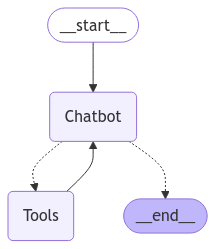

In [13]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
user_input = "what is RLHF."

event = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for query in event:
    query["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_p19b)
 Call ID: call_p19b
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an agent with human preferences. It involves training a reward model to represent preferences previously gathered from a sample of humans, which ca
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an agent with human preferences. It involves training a reward model to represent preferences previously gathered from a sample of humans, which can then be used to train a reinforcement l